In [20]:
#imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
import time
import functools

### Загрузка данных

In [12]:
data = pandas.read_csv('train.csv', sep=',').as_matrix()
samples = np.asarray(data[:35000, 1:], dtype='float')
samples /= 255
prepared_samples = np.hstack((samples, np.ones((samples.shape[0], 1))))
labels = data[:35000, 0]

test_samples = np.asarray(data[35000:, 1:], dtype='float')
test_samples /= 255
prepared_test_samples = np.hstack((test_samples, np.ones((test_samples.shape[0], 1))))
test_labels = data[35000:, 0]

### 1. Многоклассовая классификация

#### Вычислим градиент функции $Q = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W))$:
Сначала посчитаем градиент для одного семпла:

$Q(W) = -\sum_{i}[y = i]\log(p_i(W)) = -\log(p_y(W)) = -\log\frac{e^{(W\times X^T)_y}}{\sum_{j}e^{(W\times X^T)_j}} = $

$ = \log\sum_{j}e^{(W\times X^T)_j} - (W\times X^T)_y  $

Пусть $Y$ - такой вектор, что если для данного семпла $x$ правильной меткой является $m$, то $Y_m = 1, \forall i \neq m\; Y_i = 0$. Тогда мы можем представить $Q(W)$ в следующей форме:

$Q(W) = \log(\sum e^{W\times X^T}) - \sum(Y \cdot (W \times X^T)) $, где точка - поэлементное умножение, а крестик - матричное.

Это очевидным образом распространяется и на несколько семплов: $X, Y$ просто становятся матрицами.

Теперь подсчитаем градиент:
$ \nabla Q_W = (\log(\sum e^{W \times X^T}))'_W - \sum(Y \cdot (W \times X^T))'_W = \frac{(\sum exp(W \times X^T))'_W}{\sum exp(W \times X^T)} - Y^T \times X = \frac{exp(W \times X^T)\times X}{\sum exp(W \times X^T)} - Y^T \times X = softmax(W \times X^T) \times X - Y^T \times X $

In [13]:
def softmax(p):
    p = p - np.max(p, axis=0)
    return np.exp(p) / np.sum(np.exp(p), axis=0)

def loss(features, true_labels, weights):
    sm = softmax(weights @ features.T)
    return np.sum(true_labels * np.log(sm)) / features.shape[0]

def gradient(features, labels_matrix, weights):
    a = softmax(weights @ features.T)
    a = a @ features
    b = labels_matrix.T @ features
    return a - b


def get_subsets(sample_set, label_set, subset_size=1):
    perm = np.random.permutation(len(sample_set))
    shuffled_samples = sample_set[perm]
    shuffled_labels = label_set[perm]
    int_bound = len(shuffled_samples) // subset_size
    for i in range(int_bound):
        yield ((shuffled_samples[i*subset_size:(i+1)*subset_size],
                        shuffled_labels[i*subset_size:(i+1)*subset_size]))

In [14]:
current_weights = np.random.uniform(0, 1, (10, 785))
epochs = 15
batch = 300
delta = 1e-3

for i in range(epochs):  
    for subset in get_subsets(prepared_samples, labels, batch):
        marks = np.zeros((batch, 10))
        for j in range(batch):
            marks[j][subset[1][j]] = 1
        current_weights -= delta * gradient(subset[0], marks, current_weights)

In [15]:
out = softmax(current_weights @ prepared_test_samples.T)
predicted_labels = np.argmax(out, axis=0)
right = np.argmax(out, axis=0) == test_labels
print(test_labels[right].shape[0] / test_labels.shape[0])

0.9115714285714286


#### Попробуем теперь дополнительно контролировать значения весов путём небольшого изменения функции потерь:
$Q'(W) = Q(W) + \lambda_1 \sum_{i,j}|W_i^j| + \lambda_2 \sum_{i,j}(W_i^j)^2$

Градиент выражается очевидным образом:
$\nabla Q'(W) = \nabla Q(W) + \lambda_1 sign(W) + \lambda_2 \cdot 2W $

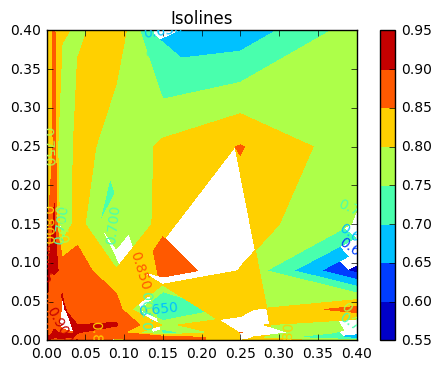

In [38]:
epochs = 10
batch = 300
delta = 1e-2
def optimize(lambda1, lambda2):
    current_weights = np.random.uniform(0, 1, (10, 785))
    for i in range(epochs):  
        for subset in get_subsets(prepared_samples, labels, batch):
            marks = np.zeros((batch, 10))
            for j in range(batch):
                marks[j][subset[1][j]] = 1
            current_weights -= delta * (gradient(subset[0], marks, current_weights)\
                                        + lambda1 * np.sign(current_weights)\
                                        + lambda2 * 2 * current_weights)
    out = softmax(current_weights @ prepared_test_samples.T)
    predicted_labels = np.argmax(out, axis=0)
    right = np.argmax(out, axis=0) == test_labels
    return test_labels[right].shape[0] / test_labels.shape[0]

# params = [x/4 for x in range(5)]
# for i in params:
#     for j in params:
#         np.random.seed(1337)
#         print('lambda1 =', i, 'lambda2 =', j, 'result:', optimize(i, j))
x = np.asarray([0, 0.004, 0.01, 0.02, 0.04, 0.09, 0.15, 0.25, 0.4])
y = x.copy()
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(optimize)
zgrid = eval_func(xgrid, ygrid)
CS = plt.contourf(xgrid, ygrid, zgrid)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
plt.colorbar(CS)
plt.axes().set_aspect('equal', adjustable='box')
plt.show()

Интересно, что значения коэффициентов нужно делать предельно малыми, так как иначе они, судя по всему, оказывают слишком большое влияние на исходную целевую функцию и перевешивают первичные признаки.

### 2. Полносвязанные нейронные сети

**Задание**
1. Предложите значения $w$ и $b$, чтобы $y$ реализовала операторы *and*, *or*, *not*.

Для начала условимся, что функция Хэвисайда задаётся, как равная единице при $arg \geq 0$ и равная нулю при $arg < 0$

Тогда:

*AND*: $\theta(w_{1}x_1 + w_{2}x_2 + b) = \theta(x_1 + x_2 - 2)$, т.е. $w_1 = w_2 = 1, b = -2 $

*OR*: $\theta(x_1 + x_2 - 1)$, т.е. $w_1 = w_2 = 1, b = -1 $

*NOT($x_1$)*: $\theta(-x_1)$, т.е. $w_1 = -1, w_2 = b = 0 $
2. Приведите пример булевой функции, которая не может быть представлена в виде $y$?

     $XOR(0, 0) = 0 \Rightarrow \theta(0w_1 + 0w_2 + b) = \theta(b) = 0 \Rightarrow b < 0$

     $XOR(0, 1) = 1 \Rightarrow \theta(w_2 + b) = 1 \Rightarrow w_2 \geq -b$
     
     $XOR(1, 0) = 1 \Rightarrow \theta(w_1 + b) = 1 \Rightarrow w_1 \geq -b$
     
     $w_1 \geq -b, w_2 \geq -b \Rightarrow w_1 + w_2 \geq -2b > -b$
     
     $XOR(1, 1) = 0 \Rightarrow \theta(w_1 + w_2 + b) = 0 \Rightarrow w_1 + w_2 < -b$, противоречие

Пусть теперь $x \in \{0, 1\}^{n}$, а $y = \theta(W_2 \cdot \theta(W_1x + b_1) + b_2)$

Аналогично обычному *AND*, $x \wedge \neg y = \theta(x - y - 2)$, $\neg x \wedge y = \theta(y - x - 2)$

Тогда если представить $F = x_1 \oplus x_2$ как $x_1 \wedge \neg x_2 \vee \neg x_1 \wedge x_2$, то $F = \theta(x_1 - x_2 - 2) \vee \theta(x_2 - x_1 - 2) = \theta(\theta_1(x_1 - x_2 - 2) + \theta_2(x_2 - x_1 - 2) - 1)$

Содержимое $\theta_1$ и $\theta_2$ получается, очевидно умножением соответствующих строк матрицы $W_1$ на вектор $x$ и прибавлением соответствующей компоненты вектора $b_1$, Содержимое внешнего $\theta$ тогда - сумма $b_2 = -1$ и скалярного произведения вектора $(\theta_1, \theta_2)$ на вектор $W_2 = (1, 1)$. Понятно, что это и есть вычисление функции $y$, таким образом, функция выразима с помощью данных средств.

Также понятно, что таким образом мы можем выразить ДНФ или КНФ, т.к. функции *AND* и *OR* без каких-либо проблем расширяются для произвольного количества переменных (положительного или отрицательного - $\neg$ - знака), которыми выражается любая логическая формула

### 3. Обучение


Реализуем с использованием библиотеки Keras простую двуслойную полносвязную сеть, где в качестве нелинейной функции используется ReLu:

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adadelta
from keras.utils import np_utils


batch_size = 128
nb_classes = 10
nb_epoch = 20

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

def train_basic_mlp(layerDimension, verbose=False):
    model = Sequential()
    model.add(Dense(layerDimension, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    if verbose:
        model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=verbose, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    return score[1]

Using TensorFlow backend.


In [176]:
train_basic_mlp(784, True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_119 (Dense)                (None, 784)           615440      dense_input_14[0][0]             
____________________________________________________________________________________________________
activation_117 (Activation)      (None, 784)           0           dense_119[0][0]                  
____________________________________________________________________________________________________
dense_120 (Dense)                (None, 10)            7850        activation_117[0][0]             
____________________________________________________________________________________________________
activation_118 (Activation)      (None, 10)            0           dense_120[0][0]                  
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
___________________

0.98280000000000001

#### Посмотрим, какое влияние оказывает размерность среднего слоя на результат:

In [4]:
dimensions = [25, 50, 100, 200, 400, 500, 600, 700, 784, 850, 1000, 1200]
accuracies = []
for d in dimensions:
    print("With the dimension size of", str(d) + ":")
    accuracies.append(train_basic_mlp(d, False))
    print('=========')

With the dimension size of 25:
Test score: 0.157798610456
Test accuracy: 0.9543
With the dimension size of 50:
Test score: 0.109032849278
Test accuracy: 0.9682
With the dimension size of 100:
Test score: 0.0899184157502
Test accuracy: 0.9734
With the dimension size of 200:
Test score: 0.0676856048829
Test accuracy: 0.979
With the dimension size of 400:
Test score: 0.0598383006258
Test accuracy: 0.9821
With the dimension size of 500:
Test score: 0.0572226089932
Test accuracy: 0.9818
With the dimension size of 600:
Test score: 0.0568535498457
Test accuracy: 0.9821
With the dimension size of 700:
Test score: 0.057714417863
Test accuracy: 0.9812
With the dimension size of 784:
Test score: 0.0562536406055
Test accuracy: 0.9817
With the dimension size of 850:
Test score: 0.0537998617765
Test accuracy: 0.983
With the dimension size of 1000:
Test score: 0.0557826054678
Test accuracy: 0.9824
With the dimension size of 1200:
Test score: 0.0546468047952
Test accuracy: 0.9835


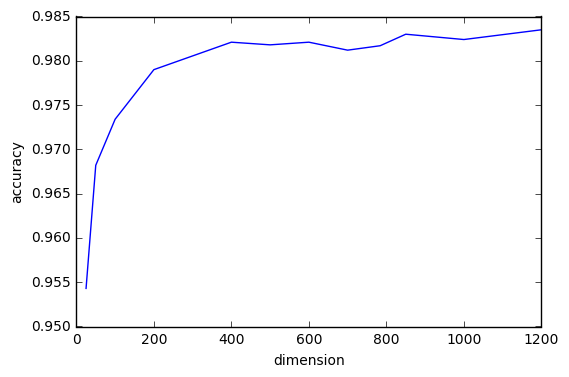

In [5]:
plt.plot(dimensions, accuracies)
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

Можно заметить, что, начиная с некоторого момента, результативность нейронной сети практически не увеличивается при изменении размерности

#### Построим следующую простейшую архитектуру:
будем повторять блоки из ReLu-активации и dropout'а, в конце используя обычный softmax. Узнаем оптимальное количество слоёв для данной архитектуры:

In [12]:
def train_custom_mlp(epochs, layerDimension, layers=1, verbose=False):
    model = Sequential()
    model.add(Dense(layerDimension, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    for i in range(layers - 1):
        model.add(Dense(layerDimension))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    if verbose:
        model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=epochs,
                        verbose=verbose, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    return score[1]

In [14]:
dimension = 850
layers = [1, 2, 3, 4, 5, 6, 7]
accuracies = []
for l in layers:
    print("With", l, "layers:")
    accuracies.append(train_custom_mlp(10, dimension, l, False))
    print('=========')

With 1 layers:
Test score: 0.0640447587996
Test accuracy: 0.9807
With 2 layers:
Test score: 0.0542461707648
Test accuracy: 0.9828
With 3 layers:
Test score: 0.0596872330021
Test accuracy: 0.9837
With 4 layers:
Test score: 0.0631443242966
Test accuracy: 0.9851
With 5 layers:
Test score: 0.0690686445606
Test accuracy: 0.9849
With 6 layers:
Test score: 0.074340841359
Test accuracy: 0.983
With 7 layers:
Test score: 0.0912560124064
Test accuracy: 0.9804


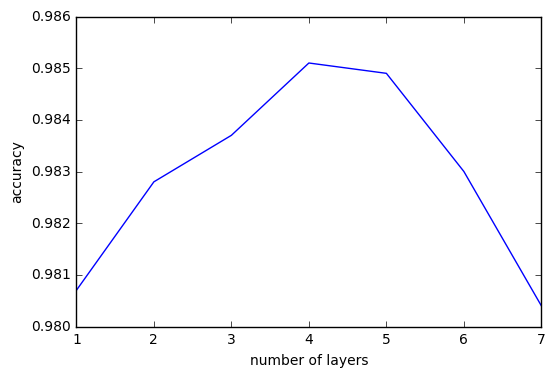

In [15]:
plt.plot(layers, accuracies)
plt.xlabel('number of layers')
plt.ylabel('accuracy')
plt.show()

График наглядно показывает, что увеличение количества слоёв не является гарантией эффективности работы нейронной сети. Наоборот, начиная с некоторого момента, происходит переобучение сети, и accuracy падает.

Попробуем построить более оригинальную архитектуру: станачала добавим автокодировщик с плавным спуском до размернсти 100, который затем повышает размерность до 800, затем несколько полносвязных слоёв с dropout'ом и вывод через softmax. Функция активации - relu

In [18]:
def train_superb_net(epochs, verbose=False):
    model = Sequential()
    
    model.add(Dense(400, input_shape=(784,)))
    model.add(Activation('relu'))
    
    model.add(Dense(200))
    model.add(Activation('relu'))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(200))
    model.add(Activation('relu'))
    
    model.add(Dense(400))
    model.add(Activation('relu'))
    
    model.add(Dense(800))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(800))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(800))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(800))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))

    if verbose:
        model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=epochs,
                        verbose=verbose, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    return score[1]
train_superb_net(30, True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_109 (Dense)                (None, 400)           314000      dense_input_13[0][0]             
____________________________________________________________________________________________________
activation_107 (Activation)      (None, 400)           0           dense_109[0][0]                  
____________________________________________________________________________________________________
dense_110 (Dense)                (None, 200)           80200       activation_107[0][0]             
____________________________________________________________________________________________________
activation_108 (Activation)      (None, 200)           0           dense_110[0][0]                  
___________________________________________________________________________________________

0.98160000000000003